## Objetivo del módulo

Conocer lo que son matrices dispersas (_**sparse**_) y su representación y manipulación en tripletas.

## Preguntas básicas

- ¿Qué es una matriz dispersa?
- ¿Qué tupos eficiencia se pueden explotar por su dispersión?
- ¿En qué complejidades computacionales incurrimos en sus distintas operaciones?
- ¿Qué compromisos de eficiencia adquirimos cons distintas representaciones?

## Introducción

En muchas ocasiones se presentan matrices en las cuales una gran cantidad de elementos son 0. Por ejemplo en sistemas de recomendación se usan matrices para representar las preferencias de millones de usuarios a millones de productos. En realidad, normalmente cada usuario valora o usa un conjunto muy pequeño de todos los productos disponibles y la matriz resultante tiene muchos ceros.

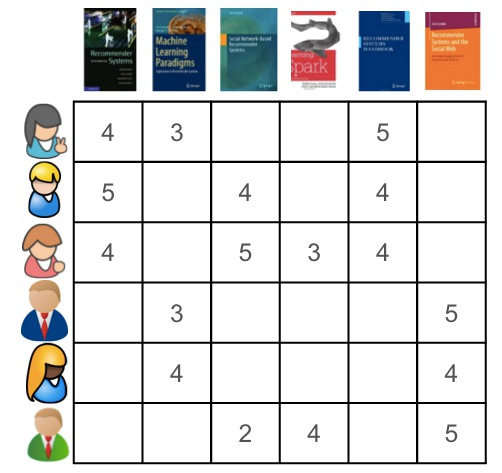

In [1]:
from IPython.display import Image
Image(filename='imgs/recommender_matrix.jpg', width=400) 

Normalmente se busca una economía de memoria en las estructuras de datos para almacenar únicamente las posiciones de la matriz con valor distinto de cero. Pero esto implica adaptar los algoritmos a dichas estructuras de datos.  

Una **métrica de dispersión** (_sparness metric_) cuantifica el grado de dispersión de una matriz. P.ej.

$$sparsness\_metric(m) = \frac{nb\_elements \ne 0}{n\_rows \times n\_cols}$$

en el caso de la figura anterior: $17/36 = 0.47$

Usaremos la siguiente clase para almacenar cada elemento con sus coordenadas en una matriz.

In [2]:
class Triplet:
    
    def __init__(self, row, col, val):
        assert isinstance(row, int) and isinstance(col, int) and row>=0 and col>=0
        
        self.row = row
        self.col = col
        self.val = val
    
    def __repr__(self):
        return "[%d %d] = %s"%(self.row, self.col, str(self.val))

In [3]:
t = Triplet(2,4,20.3)
t

[2 4] = 20.3

**clase `SparseMatrix`**: realizamos una clase que representa una matriz como una lista de tripletas, con las operaciones correspondientes sobre dicha lista.

In [4]:
import itertools

class SparseMatrix:
    
    def __init__(self, m=None):
        self.triplets = []
        self.shape = m.shape if m is not None else (0,0)
        if m is not None:
            for i,j in itertools.product(range(m.shape[0]), range(m.shape[1])):
                if m[i,j]!=0:
                    self.triplets.append(Triplet(i,j,m[i,j]))
        
    def to_dense(self):
        r = np.zeros(self.shape)
        for t in self.triplets:
            r[t.row, t.col] = t.val
        return r
    
    def sparseness_metric(self):
        return len(self.triplets) *1./(self.shape[0]*self.shape[1])
    
    def __getitem__(self, (i,j)):
        for t in self.triplets:
            if t.row==i and t.col==j:
                return t.val
        return 0

    def __setitem__(self, (i,j), val):
        if val==0:
            return
        
        for t in self.triplets:
            if t.row==i and t.col==j:
                t.val=val
                return
        self.triplets.append(Triplet(i,j,val))
        self.shape = (np.max([self.shape[0], i+1]), np.max([self.shape[1], j+1]))

    def __add__(self, m):
        r = self.__class__()
        for t in m.triplets + self.triplets:
            r[t.row, t.col] = r[t.row, t.col] + t.val
        return r
    
    def dot(self, m):
        assert self.shape[0]==m.shape[1] and self.shape[1]==m.shape[0], "incorrect dimensions %s x %s"%(str(self.shape), str(m.shape))
        
        r = self.__class__()
        for t1 in self.triplets:
            for t2 in m.triplets:
                if t1.col==t2.row:
                    r[t1.row, t2.col] = r[t1.row, t2.col] + t1.val*t2.val
        return r
            
    def T(self):
        r = self.__class__()
        for t in self.triplets:
            r[t.col, t.row] = t.val
        return r
    
   
    def __repr__(self):
        return "shape    = %s\ntriplets = %s"%(self.shape, self.triplets)

## Algorítmica implementada

### Operaciones básicas

fíjate cómo creamos una matriz dispersa como array de `numpy` de manera aleatoria

In [32]:
import numpy as np

def random_sparse_matrix(size):
    m = np.random.randint(2, size=size)
    m = m * np.random.randint(10,size=size)
    return m
m = random_sparse_matrix((5,3))
print m.shape
m

(5, 3)


array([[0, 0, 4],
       [5, 0, 0],
       [0, 0, 0],
       [3, 0, 4],
       [0, 0, 9]])

creamos la matriz dispersa y la inspeccionamos

In [6]:
sm = SparseMatrix(m)
print sm.sparseness_metric()
sm

0.333333333333


shape    = (5, 3)
triplets = [[1 2] = 2, [2 0] = 3, [2 2] = 6, [3 2] = 3, [4 2] = 1]

In [7]:
print sm.triplets

[[1 2] = 2, [2 0] = 3, [2 2] = 6, [3 2] = 3, [4 2] = 1]


In [8]:
sm.to_dense().astype(int)

array([[0, 0, 0],
       [0, 0, 2],
       [3, 0, 6],
       [0, 0, 3],
       [0, 0, 1]])

y su transpuesta

In [9]:
sm.T().to_dense().astype(int)

array([[0, 0, 3, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 2, 6, 3, 1]])

### Insercción y acceso.

Fíjate como en  Python los métodos `__getitem__` y `__setitem__` son accesibles a partir de una sintaxis especial

In [10]:
print sm.__getitem__((4,1))
print sm[4,1]

0
0


In [11]:
sm.__setitem__((4,1),17)
print sm[4,1]
sm.to_dense().astype(int)

17


array([[ 0,  0,  0],
       [ 0,  0,  2],
       [ 3,  0,  6],
       [ 0,  0,  3],
       [ 0, 17,  1]])

In [12]:
sm[4,1]=2
print sm[4,1]
sm.to_dense().astype(int)

2


array([[0, 0, 0],
       [0, 0, 2],
       [3, 0, 6],
       [0, 0, 3],
       [0, 2, 1]])

la siguiente operación llama a ambos métodos

In [13]:
sm[4,1] = sm[4,1]*2
sm.to_dense().astype(int)

array([[0, 0, 0],
       [0, 0, 2],
       [3, 0, 6],
       [0, 0, 3],
       [0, 4, 1]])

### Adición

In [14]:
(sm+sm).to_dense().astype(int)

array([[ 0,  0,  0],
       [ 0,  0,  4],
       [ 6,  0, 12],
       [ 0,  0,  6],
       [ 0,  8,  2]])

In [15]:
sm1 = SparseMatrix(random_sparse_matrix((5,3)))
sm2 = SparseMatrix(random_sparse_matrix((3,2)))
print sm1.to_dense()
print sm2.to_dense()

[[0. 0. 0.]
 [0. 0. 4.]
 [2. 0. 6.]
 [0. 2. 0.]
 [3. 8. 9.]]
[[0. 3.]
 [0. 2.]
 [0. 7.]]


In [16]:
(sm1+sm2).to_dense()

array([[0., 3., 0.],
       [0., 2., 4.],
       [2., 7., 6.],
       [0., 2., 0.],
       [3., 8., 9.]])

### Multiplicación de matrices

Revisa [Multiplicación de Matrices en Wikipedia](https://es.wikipedia.org/wiki/Multiplicaci%C3%B3n_de_matrices) si no te acuerdas cómo es esta operación

In [17]:
m1 = np.random.randint(10, size=(3,2))
print m1
m2 = np.random.randint(10, size=(2,3))
print m2
print "--"
print m1.dot(m2)
print SparseMatrix(m1).dot(SparseMatrix(m2)).to_dense().astype(int)
print "--"
print m2.dot(m1)
print SparseMatrix(m2).dot(SparseMatrix(m1)).to_dense().astype(int)

[[1 2]
 [1 3]
 [8 4]]
[[7 7 9]
 [8 4 1]]
--
[[23 15 11]
 [31 19 12]
 [88 72 76]]
[[23 15 11]
 [31 19 12]
 [88 72 76]]
--
[[86 71]
 [20 32]]
[[86 71]
 [20 32]]


## Análisis de complejidad computacional

creamos una función para que nos devuelva una matriz con elementos aleatorios

In [18]:
def random_sparse_matrix(max_rows, max_cols, n_items):
    m = SparseMatrix()
    for _ in xrange(n_items):
        i = np.random.randint(max_rows)
        j = np.random.randint(max_cols)
        v = np.random.randint(100)
        m[i,j] = v
    return m

In [19]:
k=random_sparse_matrix(1000,1000,1000)

In [20]:
k.shape, k.sparseness_metric()

((999, 999), 0.000993986979972966)

### `__setitem__`: según el tamaño de las matrices

Fíjate cómo montamos un experimento con `%timeit`. El experimento sugiere que el tiempo de ejecución no depende del tamaño de las matrices.

In [21]:
r1 = []
n1 = range(50,1000,50)
for n in n1:
    print n,
    k = %timeit -o -q -r 3 -n 3 random_sparse_matrix(n,n,1000)
    r1.append(k.best)

50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950


In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_times(n_set, r, xlabel, ylabel):
    from scipy.optimize import minimize

    n_set = np.array(n_set)
    # fit to scaled for numerical stability
    x_ticks = n_set/1e3
    r     = np.array(r)
    cfunc = lambda k, x: k[0]+k[1]*x+k[2]*x**2+k[3]*x**3
    qfunc = lambda k, x: k[0]+k[1]*x+k[2]*x**2
    lfunc = lambda k, x: k[0]+k[1]*x
    ccost = lambda k: np.mean( (r-cfunc(k, x_ticks))**2)
    qcost = lambda k: np.mean( (r-qfunc(k, x_ticks))**2)
    lcost = lambda k: np.mean( (r-lfunc(k, x_ticks))**2)
    cx    = minimize(ccost, [0,0,0,0], method="BFGS").x
    qx    = minimize(qcost, [0,0,0], method="BFGS").x
    lx    = minimize(lcost, [0,0], method="BFGS").x
    
    plt.plot(x_ticks*1e3, cfunc(cx, x_ticks), label="cubic fit", color="black")
    plt.plot(x_ticks*1e3, qfunc(qx, x_ticks), label="quadratic fit", color="black", ls="--")
    plt.plot(x_ticks*1e3, lfunc(lx, x_ticks), label="linear fit", color="black", ls=":")
    plt.plot(x_ticks*1e3, r, label="data", lw=10, alpha=.5, color="red")
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()  

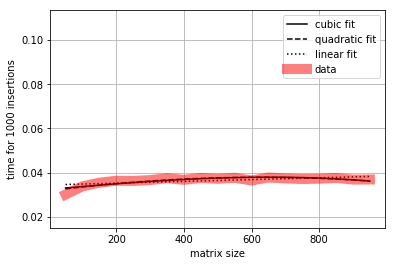

In [23]:
plot_times(n1, r1, xlabel="matrix size", ylabel="time for 1000 insertions")
plt.ylim(np.min(r1)/2, np.max(r1)*3);

### `__setitem__`: según el número de elementos insertados

El experimento sugiere una complejidad $\mathcal{O}(n^2)$. Observa el método `__setitem__`. En el peor de los casos, para insertar un elemento hay que recorrer toda la lista de tripletas. Por tanto, si $n$ es el número de tripletas, y para insertar cada elemento hay que hacer un bucle ($\mathcal{O}(n)$),  para $n$ elementos la complejidad es $\mathcal{O}(n ^2)$

In [24]:
r2 = []
n2 = range(50,3000,100)
for n in n2:
    print n,
    k = %timeit -o -q -r 3 -n 3 random_sparse_matrix(200,200,n)
    r2.append(k.best)

50 150 250 350 450 550 650 750 850 950 1050 1150 1250 1350 1450 1550 1650 1750 1850 1950 2050 2150 2250 2350 2450 2550 2650 2750 2850 2950


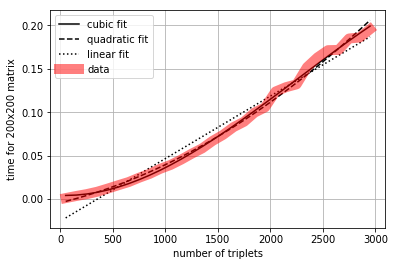

In [25]:
plot_times(n2, r2, xlabel="number of triplets", ylabel="time for 200x200 matrix")

### `__getitem__`: según el número de tripletas

El experimento sugiere una complejidad $\mathcal{O}(n^2)$. Analiza el resultado con un argumento similar al anterior. Fíjate que `__setitem__` tiene la misma complejidad pero tarda más. Las complejidades tienen el mismo orden de magnitud ($n^2$), pero difieren en una constante.

In [26]:
r1 = []
n1 = range(50,1000,50)
def getn(m,n):
    for t in m.triplets:
        m[t.row, t.col]
    
for n in n1:
    print n,
    m = random_sparse_matrix(200,200,n)
    k = %timeit -o -q -r 3 -n 3 getn(m,n)
    r1.append(k.best)

50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950


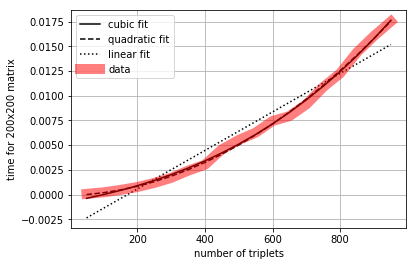

In [27]:
plot_times(n1, r1, xlabel="number of triplets", ylabel="time for 200x200 matrix")

### `__add__`: según el número de tripletas

El experimento sugiere una complejidad $\mathcal{O}(n^2)$, asumiendo que ambas matrices tienen el mismo número de tripletas. Observa que el método `__add__` realiza un `__getitem__` y un `__setitem__` por cada elemento de cada matriz:

        for t in m.triplets + self.triplets:
            r[t.row, t.col] = r[t.row, t.col] + t.val

Por tanto, la complejidad es en realidad $\mathcal{O}( 2n\times (n+n) ) = k \mathcal{O}(n^2)$ en donde:

- $2n$ es por el bucle por ambas matrices
- $n+n$ es por el `__getitem__` y por el `__setitem__`

In [28]:
r3 = []
n3 = range(50,2000,200)
for n in n3:
    print n,
    m1 = random_sparse_matrix(200,200,n)
    m2 = random_sparse_matrix(200,200,n)
    k = %timeit -o -q -r 1 -n 1 m1+m2
    r3.append(k.best)

50 250 450 650 850 1050 1250 1450 1650 1850


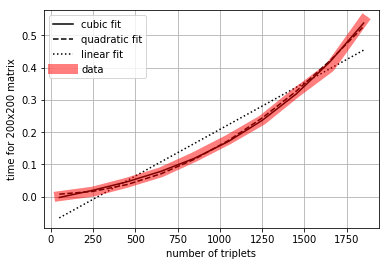

In [29]:
plot_times(n3, r3,xlabel="number of triplets", ylabel="time for 200x200 matrix")

### `dot`: según el número de triplets

El experimento sugiere una complejidad $\mathcal{O}(n^3)$. Observa el método `dot`. De nuevo, en el peor de los casos, por cada elemento tiene que realizar un bucle anidado, es decir $n^2$ iteraciones. Por tanto, con $n$ elementos tenemos $\mathcal{O}(n^3)$. Fíjate que el _fit_ cúbico ($n^3$) se ajusta mejor que el cuadrático ($n^2$). Igualmente restringimos el valor máximo de $n$ en el experimento precisamente por que esta complejidad mayor hace que se demore más.

In [30]:
r4 = []
n4 = range(50,3000,200)
for n in n4:
    print n,
    m = random_sparse_matrix(200,200,n)
    k = %timeit -o -q -r 1 -n 1 m.dot(m.T())
    r4.append(k.best)

50 250 450 650 850 1050 1250 1450 1650 1850 2050 2250 2450 2650 2850


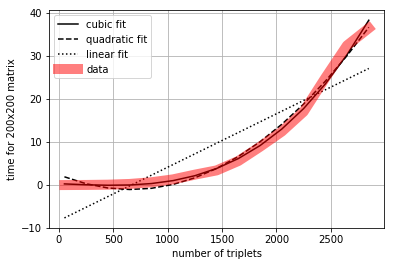

In [31]:
plot_times(n4, r4,xlabel="number of triplets", ylabel="time for 200x200 matrix")

# Preguntas y ejercicios propuestos

- ¿cómo hacer la implementación más eficiente en **get**? ¿almacenando las tripletas como un diccionario? ¿almacenando un diccionario de filas y otro de columnas?

- Python tiene una librería para tratar con matrices dispersas [`scipy.sparse`](https://docs.scipy.org/doc/scipy/reference/sparse.html), consúltala y experimenta con ella.

- Elabore algoritmo para intercambiar dos filas de una matriz representada en tripletas.

- Elabore algoritmo para intercambiar dos columnas en una matriz representada en tripletas.

- Elabore algoritmo que multiplique dos matrices representadas en tripletas.

- Elabore algoritmo que determine si una matriz representada en tripletas tiene punto de silla o no. Su algoritmo debe escribir el punto de silla y retornar verdadero si la matriz tiene punto de silla, de lo contrario debe retornar falso. Si existe, un punto de silla es el elemento (tripleta) que es el menor valor de su fila, y a la vez el mayor de su columna.

- Elabore algoritmo que determine si una matriz representada en tripletas es simétrica o no. Su algoritmo debe retornar verdadero si la matriz es simétrica, falso de lo contrario.
